In [101]:
# This is the data that is being run through the model.

target = 'MedianIncome'
age_range = '25-44'
target_fips = '34003'

params = [target_fips, age_range]



# ARIMA MODEL

- Stationary Time Series
> Stationary Time Series has no predictable patterns in the long term <br>
> and will show the series to be roughly horizontal in time plots with <br>
> constant variance<br><br>
> A time series with cyclic behavior, but no trend or seasonality is stationary.
> Because the cycles are not of a fixed length.

- Differencing
> When we compute the differences between observations to make a non-stationary <br>
> time series stationary.<br>
> ACF plot (auto correlation function plot) is useful for identifying non-stationary time series<br><br>
> in a stationary time series, the ACF drops to zero relatively quickly, <br>
> while the ACF of a non-stationary data decreases slowly. <br><br>
> For non-stationary data, the value of r1 is often large and positive

- Differenced Series
> The change between consecutive observations in the original series.<br>
> Differenced series will only have t-1 values since its not possible <br>
> to calculate the first observation.

- Random Walk Models
> Widely used for non-stationary data, particularly financial and economic data.<br>
> Random walks typically have long periods of apparent trends up or down and sudden<br>
> and unpredictable changes in direction.

In [102]:
# ARIMA MODEL
# Fit an ARIMA model.

# There are three hyperparameters we need to get values for when fitting an ARIMA model.
# Determine a value of  using the Augmented Dickey-Fuller test.

# Then, determine values of  and  through GridSearching.

# An  model is specified by:
# -how many differences  we need to calculate in order to achieve stationarity.
# -how many lags  we regress  on.
# -how many errors  we regress  on.


# Depending on our values of , , and , we might refer to these models by slightly different names.
# If  and , an AR(p) model is specified by how many lags  we regress  on.
# If  and , an MA(q) model is specified by how many errors  we regress  on.
# If , an ARMA(p, q) model is specified by how many lags  and how many errors  we regress  on.

In [103]:
import pymssql
import pandas as pd
import datetime as dt
from math import sqrt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [104]:
def plot_adf(df, target):
    fig = make_subplots(rows = 3, cols = 1)

    fig.append_trace(
        go.Scatter(
            x=df['Year'], y= df[target]
        ), row = 1, col = 1
    )

    fig.append_trace(
        go.Scatter(
            x=df['Year'], y= df['diff_1']
        ), row = 2, col = 1
    )


    fig.append_trace(
        go.Scatter(
            x=df['Year'], y= df['diff_2']
        ), row = 3, col = 1
    )


    # fig.append_trace(
    #     go.Scatter(
    #         x=df['Year'], y= df['diff_3']
    #     ), row = 4, col = 1
    # )
    fig.update_layout(height = 1000, width = 700)
    fig.show()
    
def plot_residual_errors(residuals):
    fig = px.line(y=residuals['residuals'])
    fig.show()

In [105]:
database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [106]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [107]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [108]:
all_df = run_queries()
master_table = join_tables(all_df)

5607
5607
5607
20727


## Routine
>1. Use Augmented Dickey-Fuller test to find value of P
> - This is where any differencing should occur
> - Values should be lower than 5.

In [109]:
def evaluate_models(df, p_values, d_values, q_values):
    df = df.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(df, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as E:
                    print(E)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

def get_date_range(start_date, period_range, freq):
    
    start_date = dt.datetime.strptime(str(start_date), '%Y')
    date_list = (
        pd.date_range(start=start_date, periods=period_range + 1, freq=freq)
        .to_pydatetime()
        .tolist()
    )
    date_list = [
        str(_.year) for _ in date_list
    ]
    # date_list = [dt.datetime.strptime(f'{_.year}-{_.month}-15', '%Y-%m-%d') for _ in date_list]
    return date_list[1:]

## Income Data

In [110]:
def filter_data(df, which, args):
    if which == 'MedianIncome':
        fips, age_group = args
        cols_to_keep = ['FIPS','Year','MedianIncome', 'AgeGroup']
        drop_subset = 'Year' # This will be the value checked for dups
        
        df = df[(df.FIPS == fips) & (df.AgeGroup == age_group)]
        
    filtered_df = df[[_ for _ in cols_to_keep]]
    filtered_df = filtered_df.dropna()
    filtered_df.drop_duplicates(subset = drop_subset, inplace = True)
    
    if which == 'MedianIncome':
        filtered_df['new_index'] = filtered_df.Year.copy()
        filtered_df['new_index'] = filtered_df['new_index'].apply(lambda x: dt.datetime.strptime(str(x), '%Y'))
        filtered_df.set_index('new_index', inplace = True)
    else: 
        raise ValueError("Did not set up for this dataset yet.")

    filtered_df.index = filtered_df.index.to_period('Y')
    return filtered_df

def get_adf(df, target):
    df['diff_1'] = df[target].diff()
    df['diff_2'] = df[target].diff().diff()
    #df['diff_3'] = df[target].diff().diff().diff()
    
    cols_to_check = [target, 'diff_1', 'diff_2']#,'diff_3']
    best_adf = 1000000000
    for i, col in enumerate(cols_to_check):
        adf_result = adfuller(df[col].dropna())
        if col == target:
            best_adf = adf_result[1]
        else:
            if adf_result[1] < best_adf:
                best_col = col
                best_adf = adf_result[1]
                num_diffs = i
                
        print(f'Column: {col} | ADF Statistic: {adf_result[0]} | P-Value: {adf_result[1]}')
        print(adf_result,"\n")
    return df, best_col, num_diffs

In [111]:

#plot_adf(adf_filtered_df, target)

In [112]:
# def ARIMA_predict(df, best_col):

#     y_train, y_test = train_test_split(df[best_col].dropna(), train_size = .75, shuffle = False)
#     history = [x for x in y_train]
#     predictions = []
#     # walk-forward validation
#     for t in range(len(y_test)):
#         # Best Arima is the result of grid search
#         model = ARIMA(history, order=best_arima)
#         model_fit = model.fit()
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = y_test[t]
#         history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
#     # evaluate forecasts
#     rmse = sqrt(mean_squared_error(y_test, predictions))
#     print('Test RMSE: %.3f' % rmse)
#     residuals = pd.DataFrame(model_fit.resid)
#     return predictions, model_fit, residuals, y_train, y_test  
    

# predictions, fit_model, residuals, train_set, test_set = ARIMA_predict(filtered_df, best_col)

# residuals.rename(columns = {0: 'residuals'}, inplace = True)

In [113]:
def control_arima(master_table, target, params):
    """ This function contains the meat of the ARIMA Method."""
    def ARIMA_predict(df, best_col, best_arima, num_periods):

        y_train, y_test = train_test_split(df[best_col].dropna(), train_size = .75, shuffle = False)
        model = ARIMA(y_train, order = best_arima)
        fitted = model.fit()

        predictions = fitted.forecast(num_periods, alpha=0.05)

        return predictions, y_train, y_test
    
    # Get the filtered data
    filtered_df = filter_data(master_table, target, params)
    
    # Augmented Dickey-Fuller test
    adf_filtered_df, best_col, num_diffs = get_adf(filtered_df, target)
    
    # gridsearch for hyper parameters
    best_arima = evaluate_models(
        adf_filtered_df[best_col].dropna(),
        [0,1,2,3,4,5,6],
        range(0,3),
        range(0,3)
    )
    
    # Get Arima predictions
    predictions, y_train, y_test = ARIMA_predict(
        filtered_df, best_col, best_arima, 10
    )

    # Convert returned predictions to dataframe
    predictions = predictions.reset_index().set_index('index')

    # Convert training set to dataframe
    train_set = y_train.reset_index().set_index('new_index')
    train_set.rename(columns = {best_col: 'train_set'}, inplace = True)

    # Convert testing set to dataframe
    test_set = y_test.reset_index().set_index('new_index')
    test_set.rename(columns = {best_col: 'test_set'}, inplace = True)

    # Combine testing and training and predictions (model results)
    model_result_df = pd.merge(predictions, train_set, left_index = True, right_index = True, how = 'outer')
    model_result_df = pd.merge(model_result_df, test_set, left_index = True, right_index = True, how = 'outer')

    # Combine filtered ground truth dataframe with model results
    completed_df = pd.merge(filtered_df, model_result_df, left_index = True, right_index = True, how = 'outer')

    # This will probably fail, but I don't know what to change it to yet.
    completed_df.drop(columns = ['FIPS','AgeGroup','diff_1','diff_2'], inplace = True)
    
    return completed_df, num_diffs
ready_for_undiff, num_diffs = control_arima(master_table, target, params)

Column: MedianIncome | ADF Statistic: 4.140170176639361 | P-Value: 1.0
(4.140170176639361, 1.0, 4, 10, {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}, 171.79709895218483) 

Column: diff_1 | ADF Statistic: 0.9126391187009933 | P-Value: 0.9932530731907094
(0.9126391187009933, 0.9932530731907094, 5, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, 154.4976506493853) 

Column: diff_2 | ADF Statistic: -4.891766908288081 | P-Value: 3.6184340862273524e-05
(-4.891766908288081, 3.6184340862273524e-05, 3, 9, {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}, 155.5218924050747) 

ARIMA(0, 0, 0) RMSE=7153.792


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) RMSE=6372.322


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Input contains NaN, infinity or a value too large for dtype('float64').


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Input contains NaN, infinity or a value too large for dtype('float64').


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_method

Input contains NaN, infinity or a value too large for dtype('float64').


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWar

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188:

Schur decomposition solver error.
ARIMA(2, 0, 0) RMSE=6067.546


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = r

ARIMA(2, 0, 1) RMSE=5446.652
Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered i

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\n

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 0) RMSE=4214.180


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mea

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered i

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:5

Schur decomposition solver error.
LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LU decomposition error.
Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-st

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Lik

Schur decomposition solver error.
LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Ma

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LU decomposition error.
Schur decomposition solver error.
LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\Work\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Schur decomposition solver error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LU decomposition error.
LU decomposition error.


C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Schur decomposition solver error.
Best ARIMA(3, 0, 0) RMSE=4214.180


In [114]:
# UNDIFFERENCING
#completed_df = undifference(completed_df, num_diffs)
def finalize_results(completed_df):
    completed_df['converted'] = completed_df['converted']#.shift(num_diffs)

    copy_for_graph = completed_df.reset_index().copy()
    copy_for_graph.drop(columns = ['Year'], inplace = True)
    copy_for_graph.rename(columns = {'index': "Year"}, inplace = True)

    df_for_export = copy_for_graph.copy()
    df_for_export = df_for_export[['Year',target, 'converted']]
    df_for_export.rename(columns = {'converted': 'train_and_predicted'}, inplace = True)
    print('Run Completed. Dataframes Exported: "graph_ready", "export_ready"')
    return copy_for_graph, df_for_export

In [85]:
def undifference(completed_df, num_diffs):
    
    # Shift the columns to prepare for undifferencing
    for col in ['predicted_mean','train_set','test_set']:
        completed_df[col] = completed_df[col].shift(-num_diffs)

    # Create empty column for results
    completed_df['converted'] = None
    
    # undifference the train and test set columns
    for col in ['train_set','test_set']:
        completed_df[col] = completed_df[target] + completed_df[col]
        completed_df[col] = completed_df[col].shift(num_diffs)
    
    # undifference and record the prediction results
    for i in completed_df.index.tolist():
        target_val = completed_df.loc[i, target]
        predicted_val = completed_df.loc[i, 'predicted_mean']

        
        if str(target_val) != 'nan':
            completed_df.loc[i, 'converted'] = target_val
        else:
            if str(predicted_val) != 'nan':
                last_val = completed_df.loc[i-1, 'converted'] # <- this might need to be converted to "num_diffs" instead of i-1
                completed_df.loc[i, 'converted'] = predicted_val + last_val
                
    return completed_df

#graph_ready, export_ready = control_arima(master_table, target, params)
#export_ready
undifferenced = undifference(ready_for_undiff.copy(), num_diffs)
graph_ready, export_ready = finalize_results(undifferenced)
graph_ready

Run Completed. Dataframes Exported: "graph_ready", "export_ready"


,Year,MedianIncome,predicted_mean,train_set,test_set,converted
0,2005,52040.0,NaN,NaN,NaN,52040.0
1,2006,57582.0,NaN,57582.0,NaN,57582.0
2,2007,61533.0,NaN,61533.0,NaN,61533.0
3,2008,54092.0,NaN,54092.0,NaN,54092.0
4,2009,61628.0,NaN,61628.0,NaN,61628.0
5,2010,49904.0,NaN,49904.0,NaN,49904.0
6,2011,50104.0,NaN,50104.0,NaN,50104.0
7,2012,51046.0,NaN,51046.0,NaN,51046.0
8,2013,52766.0,NaN,52766.0,NaN,52766.0
9,2014,54343.0,NaN,54343.0,NaN,54343.0


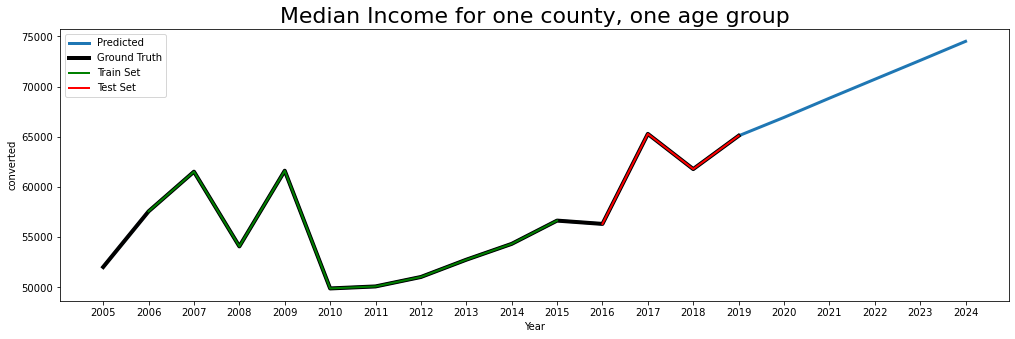

In [89]:
def graph_final_results(copy_for_graph):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_for_graph['Year'] = copy_for_graph['Year'].astype('str')

    fig = plt.figure(figsize = (17,5))
    plt.title('Median Income for one county, one age group', fontsize = 22)
    ax = sns.lineplot(x=copy_for_graph['Year'], y = copy_for_graph['converted'], linewidth=3, label = 'Predicted', )
    ax = sns.lineplot(x=copy_for_graph['Year'], y = copy_for_graph[target], linewidth = 4, color = 'black', label = 'Ground Truth')
    ax = sns.lineplot(x=copy_for_graph['Year'], y = copy_for_graph['train_set'], linewidth = 2, color = 'green', label = 'Train Set')
    ax = sns.lineplot(x=copy_for_graph['Year'], y = copy_for_graph['test_set'], linewidth = 2, color = 'red', label = 'Test Set')

    ax.invert_yaxis()
    plt.show()
    
graph_final_results(graph_ready)

In [129]:
assert 1 == 2
result_cntr = 0
target_list = ready_for_undiff['MedianIncome'].tolist()
for ii, target_val in enumerate(target_list):
    try:
        next_val = target_list[ii+3]
    except:
        continue
        
    for i, train_val in enumerate(ready_for_undiff['train_set'].tolist()):
        if (next_val == (target_val + train_val)):
            result_cntr += 1
            print(f'Target: {target_val} | Diffed: {train_val} | Result: {target_val + train_val} | Step Difference: {i-ii} | Seq: {ii}')
            break
            
if result_cntr == 0:
    print('Undifferencing indeterminate.')

Undifferencing indeterminate.
